All data cleaned using ArcGIS. Pipeline:

1) Load raster and polygon datasets into ArcGIS - project each dataset into WGS1984 projection.

2) Convert all polygon data into raster data for data compatibility.

3) Identify locations at which we have response (carbon sequestration) data - use these points to sample and access all other variables.

4) Export table of sampled variables to csv - all further manipulation done in this Jupyter Notebook.

In [4]:
#loading necessary packages 
import numpy as np
import pandas as pd
import sklearn.model_selection
import sklearn.linear_model
import sklearn.decomposition
import sklearn.ensemble
import seaborn as sns
from matplotlib import pyplot as plt

In [61]:
#read in data
predictors = pd.read_csv('pnw_predictors.txt')
carbon = pd.read_csv('pnw_c.txt')
#combine predictor variables and response variable
full_data = pd.merge(predictors, carbon, how='left', left_on=['X','Y'], right_on=['X', 'Y'])
full_data.columns
full_data

,OBJECTID_x,OR_random_Merge_x,X,Y,wc2_0_bio_10m_02,wc2_0_bio_10m_03,wc2_0_bio_10m_04,wc2_0_bio_10m_05,wc2_0_bio_10m_06,wc2_0_bio_10m_07,...,wc2_0_bio_10m_19,Bare_ground_change_1982_2016__1_,Short_vegetation_change_1982_2016,Tree_canopy_change_1982_2016,gt30w140n90,wc2_0_bio_10m_01,OBJECTID_y,OR_random_Merge_y,raster_OR_c,raster_WA_c
0,1,1,-118.512212,44.219979,12.126771,39.348040,692.443047,19.183750,-11.635500,30.819250,...,173.0,0.0,0.0,0.0,1640.0,3.852615,1,1,-0.062215,NaN
1,2,2,-118.589177,44.161284,13.415500,39.205973,750.701697,21.762751,-12.455250,34.218000,...,141.0,0.0,0.0,0.0,1585.0,4.994292,2,2,-0.062215,NaN
2,3,3,-118.606472,43.957034,15.495167,39.717957,830.716540,26.307751,-12.705250,39.013000,...,107.0,0.0,0.0,0.0,1280.0,7.335521,3,3,-0.062215,NaN
3,4,4,-118.597462,44.179292,12.126771,39.348040,692.443047,19.183750,-11.635500,30.819250,...,173.0,0.0,0.0,0.0,1536.0,3.852615,4,4,-0.062215,NaN
4,5,5,-118.548210,44.179804,12.126771,39.348040,692.443047,19.183750,-11.635500,30.819250,...,173.0,0.0,0.0,0.0,1646.0,3.852615,5,5,-0.062215,NaN
5,6,6,-118.671851,43.988574,13.593271,40.015517,741.885985,22.382999,-11.587000,33.969999,...,125.0,0.0,0.0,0.0,1253.0,5.601406,6,6,0.398544,NaN
6,7,7,-118.608878,44.022425,13.415500,39.205973,750.701697,21.762751,-12.455250,34.218000,...,141.0,0.0,0.0,6.0,1572.0,4.994292,7,7,0.398544,NaN
7,8,8,-118.709952,44.057850,12.755062,39.519640,717.653704,21.059500,-11.215750,32.275249,...,138.0,0.0,-13.0,11.0,1543.0,4.998094,8,8,0.398544,NaN
8,9,9,-118.785914,44.075481,12.755062,39.519640,717.653704,21.059500,-11.215750,32.275249,...,138.0,0.0,-17.0,16.0,1862.0,4.998094,9,9,0.398544,NaN
9,10,10,-118.700117,43.972538,13.593271,40.015517,741.885985,22.382999,-11.587000,33.969999,...,125.0,0.0,0.0,0.0,1252.0,5.601406,10,10,0.398544,NaN


In [6]:
or_sequestration = full_data[['raster_OR_c']].dropna()['raster_OR_c']
wa_sequestration = full_data[['raster_WA_c']].dropna()['raster_WA_c']
full_sequestration = list(or_sequestration)+list(wa_sequestration)
full_data['raster_OR_c'].fillna(full_data['raster_WA_c'], inplace=True)
cleaner = full_data.drop(['X', 'Y', 'OBJECTID_x', 'OR_random_Merge_x', 'OBJECTID_y', 'OR_random_Merge_y', 'raster_WA_c'], axis=1)
cleaner = cleaner.dropna()

In [ ]:
#data exploration
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[4:9])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[9:14])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[14:19])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[19:24])
sns.pairplot(data=cleaner, y_vars=['raster_OR_c'], x_vars = full_data.columns[24:27])

NameError: name 'sns' is not defined

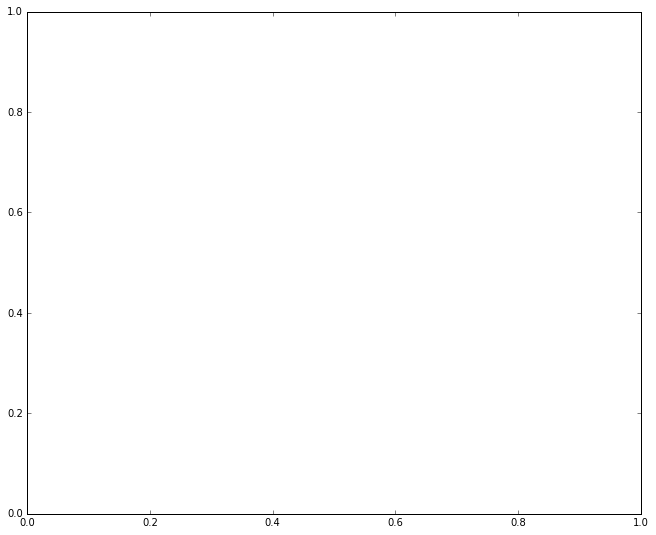

In [7]:
corr = cleaner.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr)

In [ ]:
corr[['raster_OR_c']].sort_values('raster_OR_c')

In [9]:
from sklearn import preprocessing

In [10]:
X = cleaner.iloc[:, 0:23]
standard_X = pd.DataFrame(preprocessing.scale(X))
# cleaner['raster_OR_c']
standard_X['target'] = cleaner['raster_OR_c']
standard_X.columns = cleaner.columns
standard_X.head()

,wc2_0_bio_10m_02,wc2_0_bio_10m_03,wc2_0_bio_10m_04,wc2_0_bio_10m_05,wc2_0_bio_10m_06,wc2_0_bio_10m_07,wc2_0_bio_10m_08,wc2_0_bio_10m_09,wc2_0_bio_10m_10,wc2_0_bio_10m_11,...,wc2_0_bio_10m_16,wc2_0_bio_10m_17,wc2_0_bio_10m_18,wc2_0_bio_10m_19,Bare_ground_change_1982_2016__1_,Short_vegetation_change_1982_2016,Tree_canopy_change_1982_2016,gt30w140n90,wc2_0_bio_10m_01,raster_OR_c
0,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,1.051149,-1.432185,-0.062215
1,0.981048,-0.082440,0.986583,0.447605,-1.218835,1.182900,-0.945342,-0.147397,-0.325213,-1.136788,...,-0.952842,-0.807037,-0.930314,-0.941101,-0.011519,0.096445,-0.119862,0.942904,-0.908150,-0.062215
2,1.913955,0.026676,1.684685,2.234058,-1.284569,2.165188,-0.669905,1.359685,1.239101,-0.805737,...,-1.051418,-1.080358,-1.185523,-1.040558,-0.011519,0.096445,-0.119862,0.342636,0.166486,-0.062215
3,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,0.846467,-1.432185,-0.062215
4,0.402943,-0.052162,0.478296,-0.566094,-1.003294,0.486643,-1.038166,-0.964092,-1.172924,-1.177425,...,-0.859743,-0.575764,-0.714367,-0.847494,-0.011519,0.096445,-0.119862,1.062957,-1.432185,-0.062215


In [11]:
#First approach, with standardized data
pca = sklearn.decomposition.PCA(n_components=5)
pca.fit(cleaner.iloc[:,0:23])
small = pca.transform(standard_X.iloc[:,0:23])
train_pca = pd.DataFrame(small)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_pca, cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.15102993041655488

In [12]:
#this was a first approach, attempting to use all the data, without any intelligence in picking variables
pca = sklearn.decomposition.PCA(n_components=5)
pca.fit(cleaner.iloc[:,0:23])
small = pca.transform(cleaner.iloc[:,0:23])
train_pca = pd.DataFrame(small)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(train_pca, cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.14763987524108479

So just doing dimensionality reduction of the predictor variables didn't help...

In [13]:
X_train2, X_test2, y_train2, y_test2= sklearn.model_selection.train_test_split(
cleaner.loc[:,['Bare_ground_change_1982_2016__1_','Short_vegetation_change_1982_2016','Tree_canopy_change_1982_2016']], cleaner.iloc[:,23], test_size=0.2)

In [14]:
model = sklearn.linear_model.LinearRegression()
model.fit(X_train2, y_train2)
model.score(X_train2, y_train2)

0.019869987722078042

In [15]:
X_train2, X_test2, y_train2, y_test2= sklearn.model_selection.train_test_split(
standard_X.loc[:,['Bare_ground_change_1982_2016__1_','Short_vegetation_change_1982_2016','Tree_canopy_change_1982_2016']], cleaner.iloc[:,23], test_size=0.2)
model = sklearn.linear_model.LinearRegression()
model.fit(X_train2, y_train2)
model.score(X_train2, y_train2)

0.022988123734277943

and this ^ correlation from ground change data suggests the climate data is the part that matters for the small small correlation seen in the PCA above. All the 0 values for ground change data washes out any other relationship, it looks like - it seems reasonable, though, that areas of land that experienced a ground cover change would have a relationship between the magnitude of that change and carbon sequestration rates - eg higher sequestration where canopies increased - because these are non-equilibrium sequestration rates we're seeing!

In [16]:
#one more time - choosing features slightly more intelligently after looking at scatter plots
X_train3, X_test3, y_train3, y_test3= sklearn.model_selection.train_test_split(
cleaner.loc[:,['wc2_0_bio_10m_01',
       'wc2_0_bio_10m_17', 'wc2_0_bio_10m_12', 'wc2_0_bio_10m_11',
       'wc2_0_bio_10m_07', 'wc2_0_bio_10m_06']], cleaner.iloc[:,23], test_size=0.2)
model3 = sklearn.linear_model.LinearRegression()
model3.fit(X_train3, y_train3)
print('model 3 validation r^2: ', model3.score(X_train3, y_train3))
#the following was added after the fact, upon seeing correlation go up with random forest regressor
model3_5 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model3_5.fit(X_train3, y_train3)
print('model 3.5 validation r^2: ',model3_5.score(X_train3, y_train3))
print('model 3.5 test r^2: ', model3_5.score(X_test3, y_test3))

model 3 validation r^2:  0.144498491885
model 3.5 validation r^2:  0.797761871998
model 3.5 test r^2:  0.485513420156


No need to standardize data for the random forest model.

well that's a little better, but it's clear other layers are needed. Going to make a new dataset to work with that includes some more variables that could vary on the spatial scale we're forced to work with by virtue of the seq. data not being point data, but being polygon data that covers a larger area.

List of variables for this dataset:

bioclim variables 1,4,6,11,13,16 - ones that seem to have some relationship in the scatter plot exploration, but aren't redundant: Annual Mean Temperature, Temperature Seasonality, Min Temperature of Coldest Month, Mean Temperature of Coldest Quarter, Precipitation of Wettest Month, Precipitation of Wettest Quarter. Note that this somewhat matches up with an exploration of the covariance matrice, with 6, 11, 13, and 16 being within the top 6 most positively correlated variables with the target, and 4 being within the top 2 of the most negatively correlated. 

soil characteristics: cation exchange capacity, pH*10, and soil bulk density, all at 30cm (an arbitrary choice, but deep enough to not be very variable due to topsoil processes but shallow enough for a variety of tree sizes to respond to this)

existing carbon stock - more developed forest should have lower sequestration rates and higher existing carbon stock.

exclude topography (because response variable is reported as a mean over an area with variable topography) and bare ground change/tree canopy change/short vegetation change - a dream layer would be "time since disturbance", which would be created from the 1982-2011 data on tree cover, etc. see further description of this layer in "next steps"



Data processing:

merge oregon and washington soil rasters (ph, CEC, BD) using mosaic to new raster tool

add a "num_points" field to carbon sequestration (merged polygons) attribute table that's just the number 7

use Create Random Points tool - set constraining feature class to carbon sequestration polygons, use num_points field to determine how many will be sampled in each polygon.

use Polygon to Raster tool to turn oregon carbon stock, oregon sequestration, washington carbon stock, and washington sequestration to rasters.

Use mosaic to raster to turn the sequestration rasters into one, and stock rasters into one.

FINALLY use Sample tool to find raster values at all created random points.

Export table as .txt file


In [68]:
updated_data = pd.read_csv('fixedpnwround2.txt').replace(-9999, np.nan).drop('Rowid_', axis=1).dropna()

In [ ]:
sns.pairplot(data=updated_data, x_vars=['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'COMBINED_BD'],
             y_vars=['CORRECTSEQ'], kind='reg')
sns.pairplot(data=updated_data, x_vars=['WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06'], y_vars=['CORRECTSEQ'])
sns.pairplot(data=updated_data, x_vars=['WC2_0_BIO_10M_11',
       'WC2_0_BIO_10M_13', 'WC2_0_BIO_10M_16'], y_vars=['CORRECTSEQ'])

NameError: name 'sns' is not defined

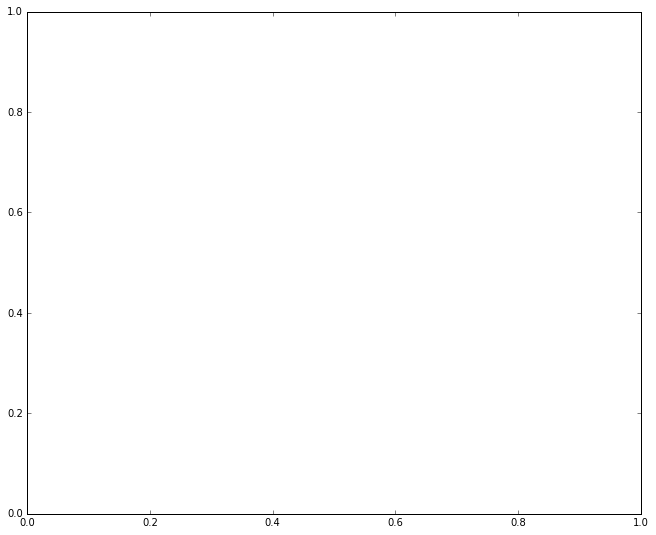

In [18]:
corr = updated_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr)

In [19]:
corr[['CORRECTSEQ']].sort_values('CORRECTSEQ')

,CORRECTSEQ
WC2_0_BIO_10M_04,-0.359209
X,-0.330338
COMBINED_PH,-0.313632
SAMPLE_POINTS,-0.030502
COMBINED_BD,0.006961
Y,0.079369
WC2_0_BIO_10M_01,0.208770
WC2_0_BIO_10M_11,0.313230
COMBINED_CEC,0.354086
WC2_0_BIO_10M_16,0.366330


In [20]:
updated_data

,SAMPLE_POINTS,X,Y,CORRECTSEQ,COMBINED_C,COMBINED_PH,COMBINED_CEC,COMBINED_BD,WC2_0_BIO_10M_01,WC2_0_BIO_10M_04,WC2_0_BIO_10M_06,WC2_0_BIO_10M_11,WC2_0_BIO_10M_13,WC2_0_BIO_10M_16
0,0,911976.617356,5.357005e+06,2.029400,167.813904,58.965643,45.590278,255.000000,7.040217,799.130967,-10.968351,-2.694131,85.337638,240.268649
1,1,901817.075322,5.363050e+06,1.789343,158.315415,54.045296,43.888858,255.000000,6.328214,782.814812,-10.779201,-3.125324,83.965263,236.661452
2,2,918805.202873,5.369724e+06,2.029400,166.737509,62.911784,30.678458,255.000000,7.120946,808.225666,-11.248461,-2.795291,90.993851,258.906722
3,3,925121.402213,5.364111e+06,0.710281,99.616169,62.480930,33.984541,255.000000,7.106221,802.095926,-11.008685,-2.680838,94.153166,268.574089
4,4,906940.305528,5.361813e+06,2.029400,167.813904,58.638708,40.451616,255.000000,6.546063,787.948963,-10.826986,-3.001255,85.298647,240.266599
5,5,923194.379255,5.360839e+06,0.830374,99.259460,60.278140,34.636584,255.000000,7.230453,804.829520,-11.070569,-2.603661,91.762996,261.060821
6,6,908695.025174,5.368566e+06,2.029400,167.813904,57.000000,38.361477,255.000000,6.258049,782.755250,-10.806530,-3.211420,88.396264,250.332797
7,7,932480.046030,5.362512e+06,0.710281,99.259460,60.000000,48.729441,255.000000,6.864768,790.867193,-10.705518,-2.708903,99.388867,284.747798
8,8,915558.044959,5.383906e+06,0.710281,99.259460,58.000000,43.401705,255.000000,6.429720,786.482773,-11.026241,-3.110087,94.124048,268.541018
9,9,905884.243682,5.387936e+06,0.770816,99.259460,55.206737,38.345037,255.000000,5.668242,767.143103,-11.017449,-3.549550,91.886374,262.602256


In [21]:
stand_update = preprocessing.scale(updated_data[[x for x in updated_data.columns if x != 'CORRECTSEQ']])
stand_update = pd.DataFrame(stand_update)
stand_update.columns = [x for x in updated_data.columns if x != 'CORRECTSEQ']
stand_update.index = updated_data.index
stand_update['CORRECTSEQ'] = updated_data['CORRECTSEQ']
stand_update['SAMPLE_POINTS'] = updated_data['SAMPLE_POINTS']
stand_update['X'] = updated_data['X'] #correcting
stand_update['Y'] = updated_data['Y']
stand_update

,SAMPLE_POINTS,X,Y,COMBINED_C,COMBINED_PH,COMBINED_CEC,COMBINED_BD,WC2_0_BIO_10M_01,WC2_0_BIO_10M_04,WC2_0_BIO_10M_06,WC2_0_BIO_10M_11,WC2_0_BIO_10M_13,WC2_0_BIO_10M_16,CORRECTSEQ
0,0,911976.617356,5.357005e+06,0.385880,0.056491,0.714672,0.086505,0.064593,1.372853,-0.778299,-0.705597,-0.668412,-0.673757,2.029400
1,1,901817.075322,5.363050e+06,0.274039,-0.701341,0.562715,0.086505,-0.289219,1.225253,-0.725898,-0.848800,-0.679458,-0.683914,1.789343
2,2,918805.202873,5.369724e+06,0.373206,0.664276,-0.617130,0.086505,0.104710,1.455126,-0.855899,-0.739193,-0.622885,-0.621279,2.029400
3,3,925121.402213,5.364111e+06,-0.417126,0.597915,-0.321858,0.086505,0.097392,1.399675,-0.789473,-0.701182,-0.597455,-0.594059,0.710281
4,4,906940.305528,5.361813e+06,0.385880,0.006136,0.255729,0.086505,-0.180964,1.271697,-0.739136,-0.807596,-0.668726,-0.673763,2.029400
5,5,923194.379255,5.360839e+06,-0.421326,0.258642,-0.263623,0.086505,0.159126,1.424404,-0.806617,-0.675551,-0.616694,-0.615213,0.830374
6,6,908695.025174,5.368566e+06,0.385880,-0.246258,0.069054,0.086505,-0.324086,1.224714,-0.733469,-0.877393,-0.643793,-0.645420,2.029400
7,7,932480.046030,5.362512e+06,-0.421326,0.215802,0.995037,0.086505,-0.022592,1.298097,-0.705485,-0.710503,-0.555313,-0.548519,0.710281
8,8,915558.044959,5.383906e+06,-0.421326,-0.092238,0.519207,0.086505,-0.238778,1.258434,-0.794337,-0.843740,-0.597690,-0.594152,0.710281
9,9,905884.243682,5.387936e+06,-0.421326,-0.522456,0.067586,0.086505,-0.617176,1.083482,-0.791901,-0.989689,-0.615701,-0.610873,0.770816


bulk density doesn't seem to matter that much, and we don't have full data on it, so I'm going to drop it from the model:

In [22]:
X_train4, X_test4, y_train4, y_test4= sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model4 = sklearn.linear_model.RidgeCV()
model4.fit(X_train4, y_train4)
model4.score(X_train4, y_train4)

0.24761865135836392

In [23]:
X_train4, X_test4, y_train4, y_test4= sklearn.model_selection.train_test_split(
stand_update.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model4 = sklearn.linear_model.RidgeCV()
model4.fit(X_train4, y_train4)
model4.score(X_train4, y_train4)

0.25406297499637387

Although this is absolutely nowhere near the predictive power we'd like, it has improved a lot from previously, showing the importance of careful feature selection!


In [32]:
X_train5, X_test5, y_train5, y_test5= sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model5 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5.fit(X_train5, y_train5)
print('training r^2: ', model5.score(X_train5, y_train5))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5.score(X_test5, y_test5))

/Users/nmushegian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


training r^2:  0.946103252107
validation r^2:  0.769353438112


In [24]:
# Last trials - splitting by geography and creating separate 
region1 = updated_data[updated_data['X']> 700000] #Arbitrary split on x >/<= 700000
region2 = updated_data[updated_data['X'] <= 700000]

In [25]:
X_train5_1, X_test5_1, y_train5_1, y_test5_1= sklearn.model_selection.train_test_split(
region1.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], region1.loc[:,['CORRECTSEQ']], test_size=0.2)
model5_1 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5_1.fit(X_train5_1, y_train5_1)
print('training r^2: ', model5_1.score(X_train5_1, y_train5_1))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5_1.score(X_test5_1, y_test5_1))

training r^2:  0.9400704252404435
validation r^2:  0.7517148887689161


/anaconda3/envs/data-x/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [26]:
X_train5_2, X_test5_2, y_train5_2, y_test5_2= sklearn.model_selection.train_test_split(
region2.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC', 'WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], region2.loc[:,['CORRECTSEQ']], test_size=0.2)
model5_2 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5_2.fit(X_train5_2, y_train5_2)
print('training r^2: ', model5_2.score(X_train5_2, y_train5_2))
#first time the r^2 is high enough that i actually want to see validation accuracy!
print('validation r^2: ', model5_2.score(X_test5_2, y_test5_2))


training r^2:  0.9519051899799262
validation r^2:  0.7283983384002892


/anaconda3/envs/data-x/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [34]:
#unfortunately i can't get soil data for canada so i wanna see how bad it is if i get rid of that
X_train5_5, X_test5_5, y_train5_5, y_test5_5 = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model5 = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
model5.fit(X_train5_5, y_train5_5)
print('training r^2: ', model5.score(X_train5_5, y_train5_5))
print('validation r^2: ', model5.score(X_test5_5, y_test5_5))
#WHOOPS it's comparable - poster already submitted though

/Users/nmushegian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


training r^2:  0.955268296501
validation r^2:  0.73387286311


Not much difference between the two models (split of around 1000 data points in region1, 1800 in region 2). This could be because the data here is quite similar, even across the two datasets - the type of region does not differ extremely across the washington/oregon region, and thus the models are extremely similar.

In [35]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [None, 10, 20, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [5, 7, 10]
}

rf = sklearn.ensemble.RandomForestRegressor(random_state = 10)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [36]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    grid_search.fit(X_train5, y_train5) # Do grid search on the original test/train split with
#updated_data

Fitting 3 folds for each of 405 candidates, totalling 1215 fits
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1, total=   0.6s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1, total=   0.7s
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=1, t

[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.6s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.6s


[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.9s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2, total=   0.5s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   1.1s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2, total=   0.5s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators

[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=3, total=   0.6s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=3, total=   0.5s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=None, min_samples_leaf=3, total=   0.7s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators

[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1, total=   0.2s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=1, total=   0.4s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimator

[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=2, total=   0.5s
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.2s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   24.7s


[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=4, max_depth=None, min_samples_leaf=3, total=   0.5s
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimator

[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.3s
[CV] bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.3s
[CV]  bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2 
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimator

[CV]  bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.6s
[CV]  bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=None, min_samples_leaf=3, total=   0.5s
[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3 
[CV] bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3 
[CV] bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3, total=   0.4s
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=3, max_depth=None, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimator

[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1, total=   0.5s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=10, min_samples_leaf=1, total=   1.0s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=10, min_samples_leaf=1, total=   1.0s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=1, total=   0.5s
[CV] bootstrap=True, n_estimators=7, max_features=

[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=2, total=   0.5s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=4, max_depth=10, min_samples_leaf=2, total=   0.7s
[CV] bootstrap=True, n_estimators=7, max_features=

[CV] bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=1, total=   0.6s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=1, total=   0.6s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=1, total=   0.3s
[CV]  bootstrap=True, n_estimators=10, max_featur

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   56.4s


[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2, total=   0.2s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=2, total=   0.4s
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=2, max_depth=10, min_samples_leaf=2, total=   0.4s
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2 
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2, total=   0.2s
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features

[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=4, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=4, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=4, max_depth=10, min_samples_leaf=3, total=   0.1s
[CV] bootstrap=True, n_estimators=5, max_features=sqrt, min_samples_split=4, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV]  bootstrap=True, n_estimators=10, max_features=sqrt, min_samples_split=3, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=7, max_features=sqrt, min_samples_split=4, max_depth=10, min_samples_leaf=3 
[CV] bootstrap=True, n_estimators=7, max_features

[CV]  bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=4, max_depth=10, min_samples_leaf=1, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=4, max_depth=10, min_samples_leaf=1 
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=4, max_depth=10, min_samples_leaf=1, total=   0.4s
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=2, total=   0.2s
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=4, max_depth=10, min_samples_leaf=1, total=   0.3s
[CV]  bootstrap=True, n_estimators=10, max_featur

[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV]  bootstrap=True, n_estimators=7, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=3, total=   0.3s
[CV] bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=3 
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=3, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=10, max_features=log2, min_samples_split=2, max_depth=10, min_samples_leaf=3, total=   0.4s
[CV] bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=3, max_depth=10, min_samples_leaf=3 
[CV]  bootstrap=True, n_estimators=5, max_features=log2, min_samples_split=3, max_depth=10, min_samples_leaf=3, total=   0.2s
[CV] bootstrap=True, n_estimators=5, max_features

[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1, total=   0.9s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1, total=   1.0s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1, total=   0.8s
[CV] bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=1 
[CV]  bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=3, max_depth=20, min_samples_leaf=1, total=   1.1s
[CV] bootstrap=True, n_estimators=5, max_feature

[CV] bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=5, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2, total=   0.4s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2, total=   0.6s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2 
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2, total=   0.6s
[CV]  bootstrap=True, n_estimators=7, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2, total=   0.7s
[CV] bootstrap=True, n_estimators=10, max_features=auto, min_samples_split=4, max_depth=20, min_samples_leaf=2 
[CV] bootstrap=True, n_estimators=5, max_features

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

In [ ]:
base_model = sklearn.ensemble.RandomForestRegressor(n_estimators =10, random_state = 10)
base_model.fit(X_train5, y_train5)
base_accuracy = base_model.score(X_test5, y_test5)
grid_accuracy = grid_search.best_estimator_.score(X_test5, y_test5)

In [31]:
print(base_accuracy, grid_accuracy)

0.7926308135104865 0.7926308135104865


In [32]:
grid_search.best_estimator_.score(X_train5, y_train5)

0.945358878461539

We tune the hyperparameters of the random forest regressor though cross-validated grid search. The final model is 1% better than the base model, although this minimal improvement is primarily due to a scarcity of data. 

In [33]:
X_train6, X_test6, y_train6, y_test6 = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model6 = sklearn.ensemble.GradientBoostingRegressor(n_estimators=10)
model6.fit(X_train6, y_train6)
print('training r^2: ', model6.score(X_train6, y_train6))
#well this isn't good - sticking to random forest classifier

training r^2:  0.4354997945064586


/anaconda3/envs/data-x/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
X_train7, X_test7, y_train7, y_test7 = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
model7 = sklearn.ensemble.ExtraTreesRegressor(n_estimators=10)
model7.fit(X_train7, y_train7)
print('training r^2: ', model7.score(X_train7, y_train7))
print('validation r^2: ', model7.score(X_test7, y_test7))

training r^2:  0.999999999943
validation r^2:  0.770252490027


/Users/nmushegian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [79]:
predictions = model7.predict(X_test7)
with_predictions = X_test7.copy()
with_predictions['Predicted Seq'] = predictions
with_predictions['Actual Seq'] = y_test7
#with_predictions = with_predictions[['Predicted Seq', 'Actual Seq']]
#with_predictions

In [102]:
canada_variables = pd.read_csv("canada_variables.txt").dropna()
canada_variables.columns = [x.upper() for x in list(canada_variables.columns)]
canada_variables['COMBINED_C'] = canada_variables['BC_FORST_CARB']
clean_canada_predictors = canada_variables.loc[:,['COMBINED_C','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']]

# create all new outputs after this heading

In [105]:
#final models to work with - includes soil data, can only be tested on test set
X_train_w_soil, X_test_w_soil, y_train_w_soil, y_test_w_soil = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','COMBINED_PH', 'COMBINED_CEC','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], 
    updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
final_model_w_soil = sklearn.ensemble.ExtraTreesRegressor(n_estimators=10)
final_model_w_soil.fit(X_train_w_soil, y_train_w_soil)

#doesn't include soil data, can be tested on test set and used to predict new values in Canada
X_train_no_soil, X_test_no_soil, y_train_no_soil, y_test_no_soil = sklearn.model_selection.train_test_split(
updated_data.loc[:,['COMBINED_C','WC2_0_BIO_10M_01',
       'WC2_0_BIO_10M_04', 'WC2_0_BIO_10M_06', 'WC2_0_BIO_10M_11', 'WC2_0_BIO_10M_13','WC2_0_BIO_10M_16']], 
    updated_data.loc[:,['CORRECTSEQ']], test_size=0.2)
final_model_no_soil = sklearn.ensemble.ExtraTreesRegressor(n_estimators=10)
final_model_no_soil.fit(X_train_no_soil, y_train_no_soil)

/Users/nmushegian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/nmushegian/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [103]:
#use y_train_w_soil and/or y_train_no_soil to make table containing anything you think would be cool to display
#join that to y_train and call it pnw_outputs i'll put it in ArcGIS
#ideas: prediction interval (https://blog.datadive.net/prediction-intervals-for-random-forests/), error, what else?

In [104]:
#use y_train_no_soil to make table containing anything else you think would be cool to display
#here we can only really do predictions i think
#join that to canada_variables and call it canada_outputs and i'll put it in ArcGIS
#ideas: prediction interval (https://blog.datadive.net/prediction-intervals-for-random-forests/), error, what else?

# we'll put wrap-up stuff after this

future datasets and how the model is going to get better:

1) worldwide data - more variability encompassed than the small differences we're trying to predict in just one forest type

2) point data rather than regional aggregate data - topography data (slope+aspect+elevation) will become useful then, as well as things like solar radiation

3) time since disturbance and other metrics of land use change - have to build this by looking at change in the hansen vegetation cover data

4) add solar radiation + windspeeds from worldclim